In [73]:

import pandas as pd
from pathlib import Path
notebook_dir = Path().absolute()
#consolidate results 
api_retrieval_results = pd.read_excel(notebook_dir.parent / 'retrieval_results' / 'api_retrieved.xlsx', sheet_name=None)  # sheet_name=None reads all sheets
embase_pmd_retrieval_results = pd.read_excel(notebook_dir.parent / 'retrieval_results' / 'api_retrieved_pubmed_embase_2ndsearch.xlsx', sheet_name=None)

# Create new xlsx file with consolidated results 
file_path = notebook_dir.parent / 'retrieval_results' / 'api_retrieved_final.xlsx'
with pd.ExcelWriter(file_path, engine='openpyxl', if_sheet_exists='replace', mode = 'a') as writer:
    # First write all sheets from api_retrieval_results
    for sheet_name, df in api_retrieval_results.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    # Then write/overwrite sheets from embase_pmd_retrieval_results (after second around)
    for sheet_name, df in embase_pmd_retrieval_results.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

# Load API results
api_results_dct = {}
excel_file = pd.ExcelFile(file_path)
for sheet in excel_file.sheet_names:
    api_results_dct[sheet] = pd.read_excel(file_path, sheet_name=sheet)

# Find Extent of Overlap Between Databases (based on Included Article ID)

c:\Users\dkraj2\Miniconda3\envs\pcosdataset\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
c:\Users\dkraj2\Miniconda3\envs\pcosdataset\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

Total unique articles: 1248
OpenAlex: 1232
Semantic Scholar: 1228
PubMed: 1163
Embase: 1209


<Figure size 1000x500 with 0 Axes>

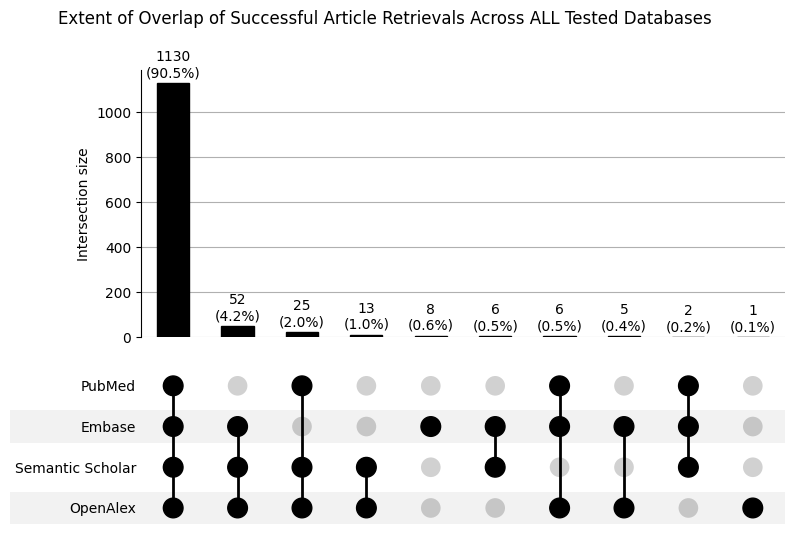

In [74]:
import upsetplot 
from upsetplot import UpSet
import pandas as pd
import matplotlib.pyplot as plt

# Calculate total unique articles

# Assuming api_results_dct contains your data
oa_successful = api_results_dct['api_results_oa'].query('(api_retrieval_success == 1)')
ss_successful = api_results_dct['api_results_ss'].query('(api_retrieval_success == 1)')
pmed_successful = api_results_dct['api_results_pubmed'].query('(api_retrieval_success == 1)')
emb_successful = api_results_dct['api_results_embase'].query('(api_retrieval_success == 1)')


# Function to get article IDs
def get_article_ids(df):
    return set(df['included_article_id'])

# Get sets of article IDs for each database
oa_ids = get_article_ids(oa_successful)
ss_ids = get_article_ids(ss_successful)
pmed_ids = get_article_ids(pmed_successful)
emb_ids = get_article_ids(emb_successful)

# Get all unique article IDs
all_ids = oa_ids.union(ss_ids, pmed_ids, emb_ids)

# Create a DataFrame with MultiIndex
data = pd.DataFrame(index=pd.MultiIndex.from_product(
    [[False, True] for _ in range(4)],
    names=['OpenAlex', 'Semantic Scholar', 'PubMed', 'Embase']
))

# Count occurrences
data['count'] = [sum((id in oa_ids) == oa and
                     (id in ss_ids) == ss and
                     (id in pmed_ids) == pmed and
                     (id in emb_ids) == emb
                     for id in all_ids)
                 for oa, ss, pmed, emb in data.index]

data = data.query('count > 0')

# Create and show the UpSet plot
colors = {
    'PubMed': '#FF9999',
    'Embase': '#66B2FF',
    'Semantic Scholar': '#99FF99',
    'OpenAlex': '#FFCC99'
}

fig = plt.figure(figsize=(10, 5))
upset_plt = upsetplot.plot(data['count'], sort_by='cardinality', show_percentages=True, show_counts = True, element_size = None, totals_plot_elements=0)

plt.suptitle('Extent of Overlap of Successful Article Retrievals Across ALL Tested Databases')
# Print some diagnostic information
print(f"Total unique articles: {len(all_ids)}")
print(f"OpenAlex: {len(oa_ids)}")
print(f"Semantic Scholar: {len(ss_ids)}")
print(f"PubMed: {len(pmed_ids)}")
print(f"Embase: {len(emb_ids)}")

#save plot as png 
plt.savefig('Figure1_overlap_plot.png', dpi = 1000)


# Plot Risk of Bias of Articles that Were Missed 

In [75]:
oa_unsucessful = api_results_dct['unsucessful_retrieve_oa']
ss_unsucessful = api_results_dct['unsucessful_retrieve_ss']
pmed_unsucessful = api_results_dct['unsucessful_retrieve_pubmed']
emb_unsucessful = api_results_dct['unsucessful_retrieve_embase']

#merge all unsuccessful articles into a single dataframe and drop duplicates 
all_unsuccessful = pd.concat([oa_unsucessful, ss_unsucessful, pmed_unsucessful, emb_unsucessful])
all_unsuccessful_nodupe = all_unsuccessful.drop_duplicates(subset = ['included_article_id']).set_index('included_article_id')

# Modified merge code
columns_to_add = []
for database, sucessful_df in zip(['oa', 'ss', 'pmed', 'emb'], [oa_successful, ss_successful, pmed_successful, emb_successful]):

    sucessful_df_extract = sucessful_df[['included_article_id', 'api_id_retrieved']].copy().set_index('included_article_id')
    sucessful_df_extract.rename(columns = {'api_id_retrieved': f'{database}_retrieved_id'}, inplace = True)
    merged_df = all_unsuccessful_nodupe.join(sucessful_df_extract, how = 'left')
    all_unsuccessful_nodupe[f'{database}_retrieved_id'] = merged_df[f'{database}_retrieved_id']
    columns_to_add.append(f'{database}_retrieved_id')

all_unsuccessful_nodupe.reset_index(inplace = True)
all_unsuccessful_nodupe_selected = all_unsuccessful_nodupe[['included_article_id', 'GDG', 'question_id', 'included_reference', 'year_pub_extract','author_year_format']+ columns_to_add].copy()
all_unsuccessful_nodupe_selected['no_api_retrieved'] = (all_unsuccessful_nodupe_selected['oa_retrieved_id'].isna() & all_unsuccessful_nodupe_selected['ss_retrieved_id'].isna() & all_unsuccessful_nodupe_selected['pmed_retrieved_id'].isna() & all_unsuccessful_nodupe_selected['emb_retrieved_id'].isna()).astype(int)
all_unsuccessful_nodupe_selected.to_csv('all_unsuccessful_nodupe_debugged.csv')


## Joining Rob Assessment to Unsuccessful Articles (After Fixing Bugs and Extracting Original Assessments)

In [76]:
debugged_unsuccessful = pd.read_csv('all_unsuccessful_nodupe_debugged.csv').reset_index().set_index('included_article_id').drop(columns = ['Unnamed: 0'])
#conpare length 
all_unsucessful_rob_fixed = pd.read_csv('all_unsuccessful_nodupe_rob_FIXED.csv').reset_index().set_index('included_article_id').drop(columns = ['Unnamed: 0'])
all_unsucessful_rob_updated = debugged_unsuccessful.join(all_unsucessful_rob_fixed['rob'], how = 'left')
all_unsucessful_rob_updated.sort_index(inplace = True)
all_unsucessful_rob_updated.to_csv('all_unsuccessful_nodupe_rob_FINAL.csv')
all_unsucessful_rob_updated['rob'] = all_unsucessful_rob_updated['rob'].str.strip()

oa_unsucessful_with_rob = oa_unsucessful.set_index('included_article_id').join(all_unsucessful_rob_updated[['rob']], how='left')
oa_unsucessful_with_rob.reset_index(inplace = True)

ss_unsucessful_with_rob = ss_unsucessful.set_index('included_article_id').join(all_unsucessful_rob_updated[['rob']], how='left')
ss_unsucessful_with_rob.reset_index(inplace = True)

pmed_unsucessful_with_rob = pmed_unsucessful.set_index('included_article_id').join(all_unsucessful_rob_updated[['rob']], how='left')
pmed_unsucessful_with_rob.reset_index(inplace = True)

emb_unsucessful_with_rob = emb_unsucessful.set_index('included_article_id').join(all_unsucessful_rob_updated[['rob']], how='left')
emb_unsucessful_with_rob.reset_index(inplace = True)




In [77]:
#plot rob by database, percentage as bar chart 
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the data
databases = {
    'OpenAlex': oa_unsucessful_with_rob,
    'Semantic Scholar': ss_unsucessful_with_rob,
    'PubMed': pmed_unsucessful_with_rob,
    'Embase': emb_unsucessful_with_rob
}

# Step 2: Calculate percentages for each RoB category in each database
rob_percentages = {}
rob_counts = {}
for db_name, df in databases.items():
    total = df['rob'].notna().sum()
    rob_percentages[db_name] = df['rob'].value_counts(normalize=True).mul(100).round(2)
    rob_counts[db_name] = df['rob'].value_counts()

# Step 3: Prepare data for plotting
rob_categories = ['low', 'moderate', 'high', 'insufficient information']
data = {cat: [rob_percentages[db].get(cat, 0) for db in databases.keys()] for cat in rob_categories}


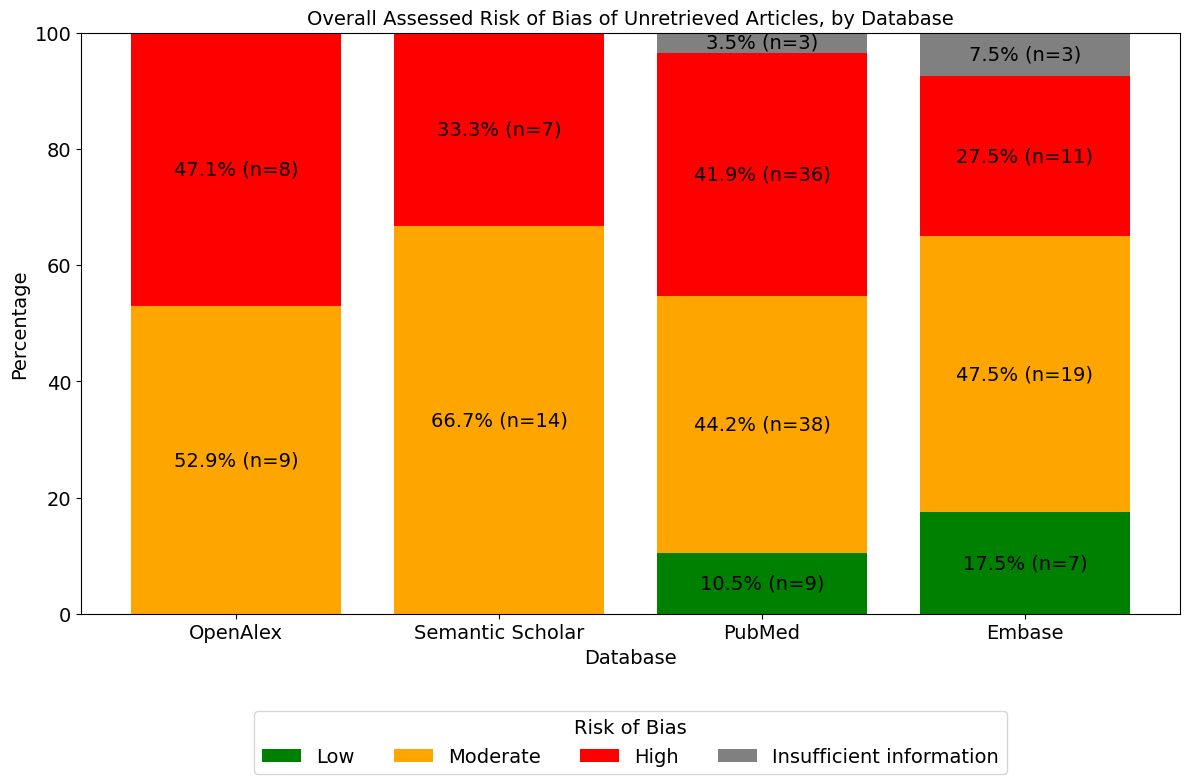

In [78]:

# Step 4: Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each RoB category
colors = {'low': 'green', 'moderate': 'orange', 'high': 'red', 'insufficient information': 'grey'}

bottom = np.zeros(len(databases))
for cat in rob_categories:
    ax.bar(databases.keys(), data[cat], bottom=bottom, label=cat.capitalize(), color=colors[cat])
    bottom += data[cat]

ax.set_title('Overall Assessed Risk of Bias of Unretrieved Articles, by Database', fontsize=14)
ax.set_xlabel('Database', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.legend(title='Risk of Bias', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, fontsize=14, title_fontsize=14)
ax.set_ylim(0, 100)

# Add percentage labels and n= on the bars
for i, db in enumerate(databases.keys()):
    total = sum(data[cat][i] for cat in rob_categories)
    y_offset = 0
    for cat in rob_categories:
        height = data[cat][i]
        if height > 0:
            count = rob_counts[db].get(cat, 0)
            ax.text(i, y_offset + height/2, f'{height:.1f}% (n={count})', 
                    ha='center', va='center', fontsize=14)
        y_offset += height

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('Figure2_rob_plot.png', dpi = 1000)
plt.show()




